In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
contamination = 0.1 # percentage of outliers
n_train = 500 # number of training points
n_test = 500 # number of testing points
n_features = 25 # number of features

In [3]:
X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features=n_features, contamination=contamination, random_state=1234
)

In [4]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [5]:
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [6]:
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1', 'PC2']

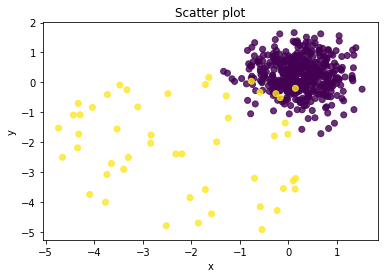

In [7]:
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Model 1 - Build Model

In [8]:
clf1 = AutoEncoder(hidden_neurons=[25, 2, 2, 25])
clf1.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

450/450 [==============================] - 0s 185us/step - loss: 9.7582 - val_loss: 8.7067
Epoch 59/100
450/450 [==============================] - 0s 208us/step - loss: 9.6171 - val_loss: 8.5854
Epoch 60/100
450/450 [==============================] - 0s 233us/step - loss: 9.4786 - val_loss: 8.4666
Epoch 61/100
450/450 [==============================] - 0s 237us/step - loss: 9.3422 - val_loss: 8.3504
Epoch 62/100
450/450 [==============================] - 0s 140us/step - loss: 9.2117 - val_loss: 8.2369
Epoch 63/100
450/450 [==============================] - 0s 222us/step - loss: 9.0803 - val_loss: 8.1245
Epoch 64/100
450/450 [==============================] - 0s 209us/step - loss: 8.9545 - val_loss: 8.0141
Epoch 65/100
450/450 [==============================] - 0s 135us/step - loss: 8.8311 - val_loss: 7.9069
Epoch 66/100
450/450 [==============================] - 0s 154us/step - loss: 8.7093 - val_loss: 7.8016
Epoch 67/100
450/450 [==============================] - 0s 141us/step - loss:

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff52c433b00>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

### Determine the Cut Point

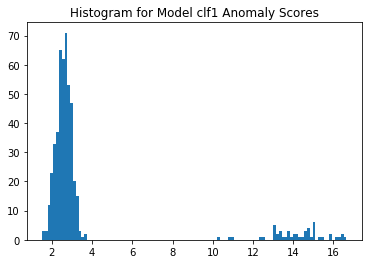

In [9]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_

# Predict the anomaly scores
y_test_scores = clf1.decision_function(X_test) # outlier scores
y_test_scores = pd.Series(y_test_scores)

plt.hist(y_test_scores, bins="auto")
plt.title("Histogram for Model clf1 Anomaly Scores")
plt.show()

### Get the summary Statistics by Cluster

In [10]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

0    450
1     50
Name: cluster, dtype: int64

In [11]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.589629
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,14.175334


### Model 2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_7 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

450/450 [==============================] - 0s 299us/step - loss: 4.1088 - val_loss: 4.1479
Epoch 57/100
450/450 [==============================] - 0s 238us/step - loss: 4.0321 - val_loss: 4.0955
Epoch 58/100
450/450 [==============================] - 0s 264us/step - loss: 3.9922 - val_loss: 4.0452
Epoch 59/100
450/450 [==============================] - 0s 221us/step - loss: 3.9502 - val_loss: 3.9963
Epoch 60/100
450/450 [==============================] - 0s 323us/step - loss: 3.9042 - val_loss: 3.9490
Epoch 61/100
450/450 [==============================] - 0s 348us/step - loss: 3.8167 - val_loss: 3.9016
Epoch 62/100
450/450 [==============================] - 0s 211us/step - loss: 3.7532 - val_loss: 3.8599
Epoch 63/100
450/450 [==============================] - 0s 302us/step - loss: 3.7003 - val_loss: 3.8163
Epoch 64/100
450/450 [==============================] - 0s 195us/step - loss: 3.6607 - val_loss: 3.7712
Epoch 65/100
450/450 [==============================] - 0s 232us/step - loss:

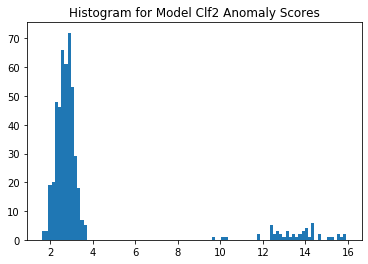

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.715401
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.497937


In [12]:
clf2 = AutoEncoder(hidden_neurons=[25, 10, 2, 10, 25])
clf2.fit(X_train)

y_test_scores = clf2.decision_function(X_test)
y_test_scores = pd.Series(y_test_scores)

plt.hist(y_test_scores, bins='auto')
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
# df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

### Model 3 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_14 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_16 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 15)               

450/450 [==============================] - 0s 485us/step - loss: 4.5030 - val_loss: 4.2201
Epoch 52/100
450/450 [==============================] - 0s 337us/step - loss: 4.3772 - val_loss: 4.1515
Epoch 53/100
450/450 [==============================] - 0s 490us/step - loss: 4.3049 - val_loss: 4.0821
Epoch 54/100
450/450 [==============================] - 0s 774us/step - loss: 4.2258 - val_loss: 4.0216
Epoch 55/100
450/450 [==============================] - 0s 514us/step - loss: 4.1497 - val_loss: 3.9583
Epoch 56/100
450/450 [==============================] - 0s 340us/step - loss: 4.0934 - val_loss: 3.8997
Epoch 57/100
450/450 [==============================] - 0s 340us/step - loss: 4.0339 - val_loss: 3.8386
Epoch 58/100
450/450 [==============================] - 0s 380us/step - loss: 3.9382 - val_loss: 3.7822
Epoch 59/100
450/450 [==============================] - 0s 627us/step - loss: 3.8819 - val_loss: 3.7290
Epoch 60/100
450/450 [==============================] - 0s 512us/step - loss:

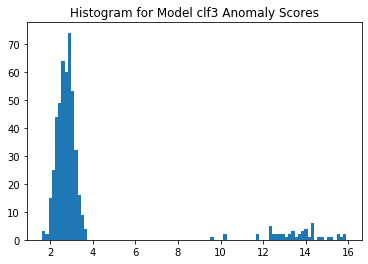

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.721570
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.480548


In [13]:
clf3 = AutoEncoder(hidden_neurons=[25, 15, 10, 2, 10, 15, 25])
clf3.fit(X_train)

y_test_scores = clf3.decision_function(X_test)
y_test_scores = pd.Series(y_test_scores)

plt.hist(y_test_scores, bins='auto')
plt.title("Histogram for Model clf3 Anomaly Scores")
plt.show()

df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score'] < 4, 0, 1)
# df_test['cluster'].value_counts()
df_test.groupby('cluster').mean()

**Although unsupervised techniques are powerful in detecting outliers, they are prone to overfitting and unstable results. The solution is to train multiple models then aggregate the scores.**

There are four methods to aggregate the outcome as below.
- Average: average scores of all detectors.
- Maximum of Maximum (MOM)
- Average of Maximum (AOM)
- Maximum of Average (MOA)

In [14]:
train_scores = pd.DataFrame({
    'clf1': clf1.decision_scores_,
    'clf2': clf2.decision_scores_,
    'clf3': clf3.decision_scores_
})

test_scores = pd.DataFrame({
    'clf1': clf1.decision_function(X_test),
    'clf2': clf2.decision_function(X_test),
    'clf3': clf3.decision_function(X_test)
})

In [19]:
train_scores

,clf1,clf2,clf3
0,2.579763,2.755558,2.751970
1,2.504297,2.684657,2.699971
2,2.633144,2.804979,2.819828
3,2.490051,2.607970,2.611626
4,2.228839,2.266964,2.257286
...,...,...,...
495,14.976967,14.263986,14.243534
496,15.549983,14.853727,14.829796
497,14.789483,14.105426,14.086294
498,13.339385,12.663587,12.647053


In [17]:
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

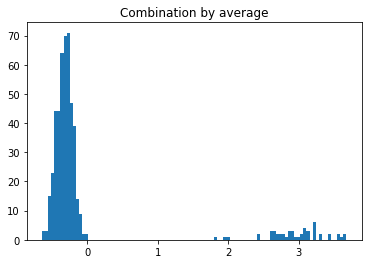

In [22]:
y_by_average = average(test_scores_norm)

plt.hist(y_by_average, bins='auto')
plt.title('Combination by average')
plt.show()

In [23]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    450
1     50
Name: y_by_average_cluster, dtype: int64

In [25]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,-0.325582
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,2.952716
